In [104]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
XCr_path = os.getcwd()+'/../'
sys.path.append(XCr_path)
from XCrystal import *
from scipy.spatial.transform import Rotation as R

## Loading XCrystal configuration

In [136]:
xcr = XCrystal(XCr_path+'/config/C400_9p8keV_LaueAssymRefl15degFig2.yaml')
pp=xcr.configure(0,0)

No deformation model was selected


## Rotation function

In [137]:
def rotate_sphere_xcr(xcr, sphere_center, radius, rotation_axis, rotation_angle, hemisphere='upper'):
    
    x = xcr.xx
    y = xcr.yy
    z = xcr.z
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Stack the coordinates
    coords = np.stack((X, Y, Z), axis=-1) - sphere_center

    # Create rotation matrix
    rotation = R.from_rotvec(np.deg2rad(rotation_angle) * np.array(rotation_axis))
    rotation_matrix = rotation.as_matrix()

    # Apply rotation
    rotated_coords = np.tensordot(coords, rotation_matrix, axes=([3], [1]))
    
    distance_squared = (rotated_coords[..., 0] ** 2 + rotated_coords[..., 1] ** 2 + rotated_coords[..., 2] ** 2)


    # Condition for points inside the sphere
    sphere_condition = distance_squared <= radius ** 2
    
    # Condition for the hemisphere
    if hemisphere == 'upper':
        hemisphere_condition = rotated_coords[..., 0] <= sphere_center[0]
    elif hemisphere == 'lower':
        hemisphere_condition = rotated_coords[..., 0] >= sphere_center[0]
    else:
        raise ValueError("hemisphere must be 'upper' or 'lower'")

    # Combine conditions
    sphere_mask = sphere_condition & hemisphere_condition

    return sphere_mask

## Create boolean mask for where the crystal is

In [138]:
XCrArray = np.zeros((np.shape(xcr.xx)[0], np.shape(xcr.yy)[0], np.shape(xcr.z)[0]))
mask1 = rotate_sphere_xcr(xcr, (xcr.xs, 0, 0), 350.0 * 1e-6 * xcr.convr, (0, 1, 0), 0.0)

In [139]:
XCrArray[mask1]=True

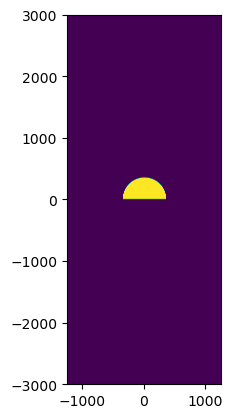

In [143]:
plt.imshow(XCrArray[:,1,:], extent=[min(xcr.z)/ 1e-6 / xcr.convr, max(xcr.z) / 1e-6 / xcr.convr, min(xcr.xx) / 1e-6  / xcr.convr, max(xcr.xx) / 1e-6 / xcr.convr], aspect='equal')

## Save the mask in the geometry file

In [141]:
np.save('Asymm-sphere.geom',mask1) 